# Step 1: Introduction to calibration

## What is calibration/optimization/parameter estimation?

- General definition

- black box model (parameters > model > outputs)
- parameters and outputs must be formally defined.

## Some useful definitions

- gradient based vs global
- single vs multi-objective
- complex model vs statistical surogate
- a method that provides parameter uncertainty or just best parameter set
- constrained vs unconstrained

# Step 2: Problem statement and dataset

Today's clinic will use a model of 1D diffusion of heat in the Earth's crust and data from [Clow (2014)](https://www.earth-syst-sci-data.net/6/201/2014/essd-6-201-2014.pdf).


In [19]:
import os
import glob
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

from plotnine import *

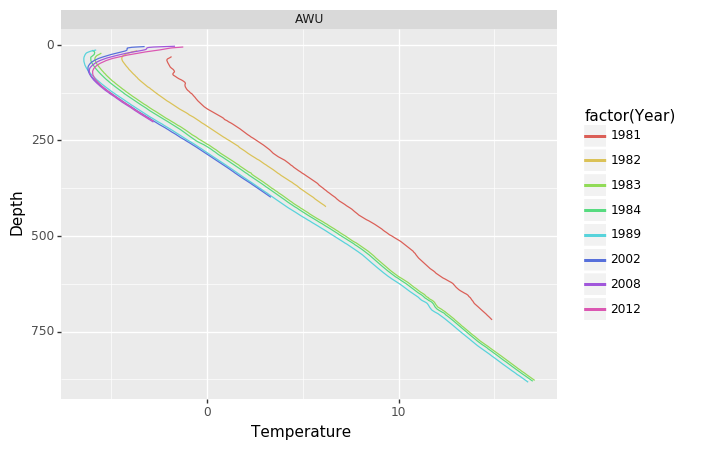

<ggplot: (-9223372036568572167)>

In [3]:
files = glob.glob(os.path.join("resources", "clow_2014", "G10015", "AWU*.txt"))
dfs = []
for path in files:
    date = os.path.split(path)[-1].split(".")[0].split("_")[-1]
    site = os.path.split(path)[-1].split(".")[0].split("_")[0]
    year = int(date[:2])
    if year<19:
        year += 2000
    else:
        year += 1900
    tdf = pd.read_csv(path, header=22, skip_blank_lines=False, sep="\s+")
    tdf["Date"] = date
    tdf["Year"] = year
    tdf["Site"] = site
    dfs.append(tdf)
df = pd.concat(dfs).sort_values(["Site", "Date", "Depth"]).reset_index(drop=True)

(ggplot(df, aes(x="Temperature", y="Depth", color="factor(Year)")) +
 geom_path(na_rm=True) + 
 facet_wrap("~Site") +
 scale_y_reverse())


# Step 3: Model, parameters and objective function.

- diffusion of heat + surface temperature history
- OF based on fitting Clow paper data using an RMSE

# Step 4: Introduction to Dakota

[Dakota](https://dakota.sandia.gov)

[Online Documentation](https://dakota.sandia.gov/content/69-reference-manual)

[PDFs to download](https://dakota.sandia.gov/content/manuals)

- Dakota has more bells and whistles, it is well thought out, and the
  documentation is quite good. Its just extensive and not an iPhone.
- Dakota has a gui if your into that.
- There are lots of hierarchical type things you can do.
- Restart utility, deprepro, and pyprepro....
- Core activity (assuming you have a black box model set up) is to create and
  run an input file.
- Dakota then iteratively runs your model for you to determine parameter values.  

What we will do:
- Look at .in file.
    * discuss each part
- Look at template file and driver.py (connect this with black box parts)
- Run Dakota, create plots, look at output.
- Discuss Dakota's file structure

In [1]:
! cat analysis/dakota_01_grid.in

# Dakota input file
environment
  tabular_data
    tabular_data_file "dakota_01_grid.dat"

method
  multidim_parameter_study
  partitions 9 9

variables
  continuous_design 2
    descriptors "T" "duration_years"
    lower_bounds -10 20
    upper_bounds 2 120

interface
  fork
    asynchronous
    evaluation_concurrency 1
    parameters_file "params.in"
    results_file "results.out"
    copy_files "template_dir/*"

    analysis_driver "python driver.py"

    work_directory
      named "MULTIDIM_PARAM/run"
      directory_tag
      directory_save
      file_save

responses
  calibration_terms 1
  response_descriptors "rmse"
  no_gradients
  no_hessians


In [2]:
! cat analysis/template_dir/driver.py

# Import  modules
import sys
from subprocess import call

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from six import StringIO
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from yaml import safe_load

from heat import BmiHeat as Heat

# Set physical constants
seconds_per_year = 365.25 * 24 * 60 * 60
seconds_per_day = 24 * 60 * 60
Qm = 0.05  # Heat Flux W m**2 = J s m**2
rho = 2600  # Density of Rock kg m**(-3)
c = 2000  # Heat Capacity of Rock J kg**(-1) K**(-1)

#########################################
#                                       #
#    Step 1: Use Dakota created         #
#    input files to prepare for         #
#    model run.                         #
#                                       #
#########################################
input_template = "input_template.yml"
inputs = "inputs.yml"
call(["dprepro", sys.argv[1], input_template, inputs])
call(['rm', input_template])

########################

In [12]:
os.chdir("analysis")
! source start_01_grid.sh

Lets go look at the file strucure. 

In [13]:
! cat dakota_01_grid.out

Dakota version 6.9 released Jan 29 2019.
Repository revision 32b6d4b (2018-11-12) built Jan 29 2019 16:16:52.
Running MPI Dakota executable in serial mode.
Start time: Wed May  8 21:19:11 2019

-----------------------
Begin DAKOTA input file
dakota_01_grid.in
-----------------------
# Dakota input file
environment
  tabular_data
    tabular_data_file "dakota_01_grid.dat"

method
  multidim_parameter_study
  partitions 9 9

variables
  continuous_design 2
    descriptors "T" "duration_years"
    lower_bounds -10 20
    upper_bounds 2 120

interface
  fork
    asynchronous
    evaluation_concurrency 1
    parameters_file "params.in"
    results_file "results.out"
    copy_files "template_dir/*"

    analysis_driver "python driver.py"

    work_directory
      named "MULTIDIM_PARAM/run"
      directory_tag
      directory_save
      file_save

responses
  calibration_terms 1
  response_descriptors "rmse"
  no_gradients
  no_hessians
---------------------
End DAKOTA input file
------------

# Other methods
We just did a brute force grid search. This is sort of an optimization.
Next we will do a gradient based method and a global method.

What's different about their input files. 
- Gradients  are necessary for NL2SOL
- Seed is necessary for EGO (or a default is used)


In [ ]:
! cat dakota_02_nl2sol.in

In [14]:
! cat dakota_03_ego.in


# Dakota input file
environment
  tabular_data
    tabular_data_file "dakota_03_ego.dat"

method
  efficient_global
  seed 42

variables
  continuous_design 2
    descriptors "T" "duration_years"
    lower_bounds -10 20
    upper_bounds 2 120

interface
  fork
    asynchronous
    evaluation_concurrency 1
    parameters_file "params.in"
    results_file "results.out"
    copy_files "template_dir/*"

    analysis_driver "python driver.py"

    work_directory
      named "EGO/run"
      directory_tag
      directory_save
      file_save

responses
  calibration_terms 1
  response_descriptors "rmse"
  no_gradients
  no_hessians


In [ ]:
! source start_02_nl2sol.sh
! source start_03_ego.sh

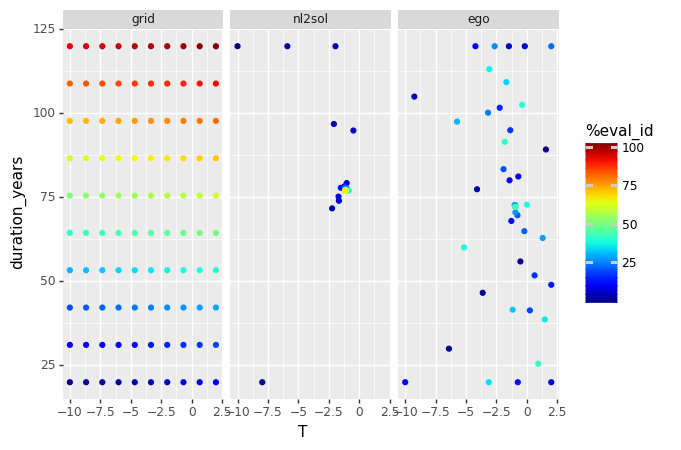

<ggplot: (285589473)>

In [16]:
files = glob.glob("*.dat")
dfs = []
for file in files:
    df = pd.read_csv(file, engine="python", sep="\s+")
    df["method"] = file.split('.')[0].split("_")[-1]
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
method_cats = CategoricalDtype(categories=["grid", 
                                           "nl2sol", 
                                           "ego"], 
                               ordered=True)
df["method"] = df["method"].astype(method_cats)
df = df.set_index(["method", "T", "duration_years"]).drop(columns=["interface"])

# plot evaluations
(ggplot(df.reset_index(), aes(x="T", y="duration_years", color="%eval_id")) + 
     geom_point() + 
     scale_color_cmap(name='jet') +
     facet_wrap("~method"))



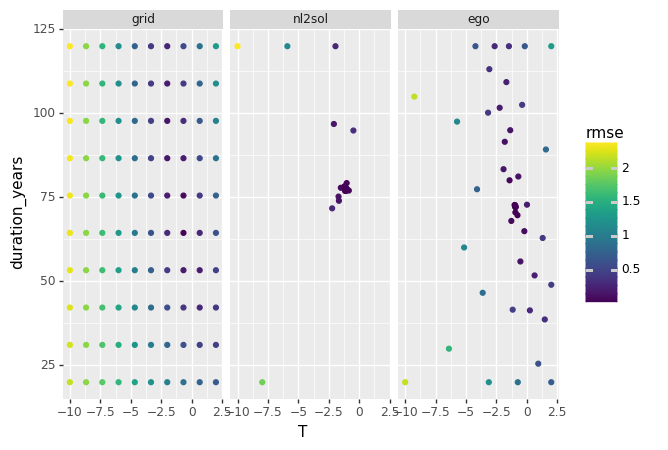

<ggplot: (-9223372029297477516)>

In [17]:

(ggplot(df.reset_index(), aes(x="T", y="duration_years", color="rmse")) + 
     geom_point() + 
     facet_wrap("~method"))


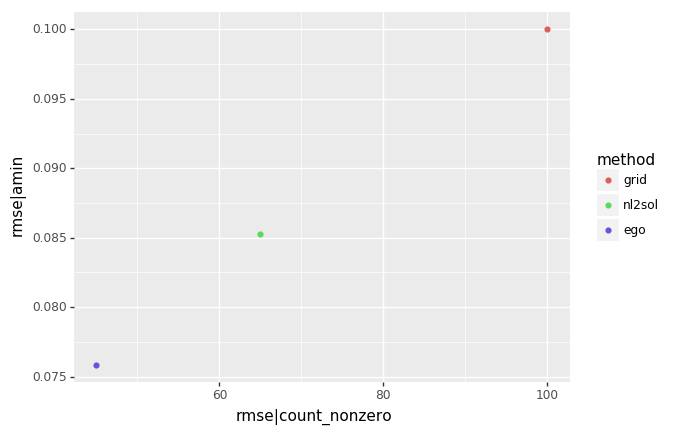

<ggplot: (7557961494)>

In [20]:
# see how results and number of evaluations are influenced by method
sum_df = df.drop(columns=["%eval_id"]).groupby("method").agg([np.count_nonzero, np.min])
sum_df.columns = sum_df.columns.map('|'.join).str.strip('|')

(ggplot(sum_df.reset_index(), (aes(x="rmse|count_nonzero", y="rmse|amin", color="method"))) + geom_point())


In [21]:

# summarized best Ts and durations
best_df=df[df.rmse.isin(sum_df["rmse|amin"].values)].reset_index()
print(best_df)

   method         T  duration_years  %eval_id      rmse
0     ego -0.944669       72.126169        32  0.075839
1    grid -0.666667       64.444444        48  0.100030
2  nl2sol -1.127754       77.049685        63  0.085272


# Discussion:
- computational cost of Dakota method vs complex model evaluation.
    * calculation of numerical gradients
    * increasing dimension
- do you need parameter estimates, or just a best fit point.
- RST file, .out file and reproducible research
- We haven't yet talked about the uncertainty estimates on  parameters, just
  which parameter is best. That is for another day.

# Exploration if time:
* Explore other optimization methods. Start by going to the [Online Reference Manual](https://dakota.sandia.gov/content/69-reference-manual) and selecting Topics Area > Methods > Optimization and Calibration
* Add a second component of the objective function.
* Make the model (of surface temperature history) more complex.
